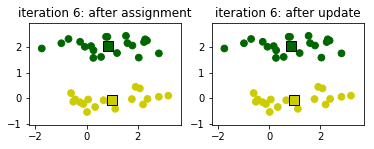

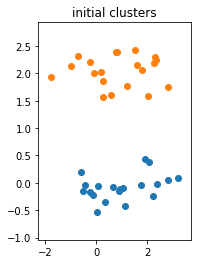

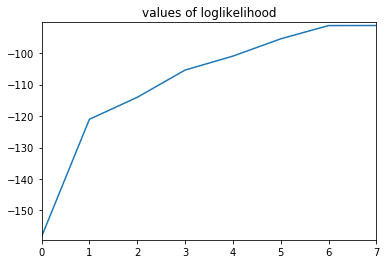

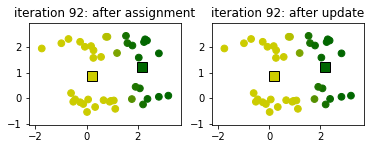

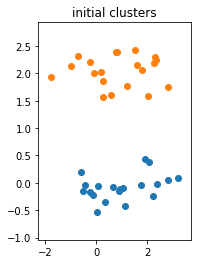

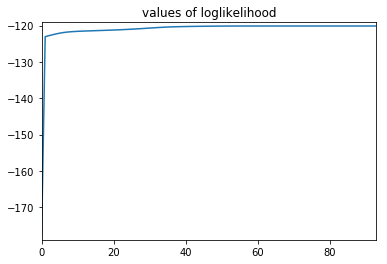

In [5]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from math import sqrt, pi
from matplotlib.widgets import Slider, Button
np.random.seed(3)

colors = ["#cccc00", "#006600", "m", "b", "r"]

def EM(data, K, m, n_iter = 25, return_all_iterations=False, random_choice=True):
    N, M = data.shape # N is number of data points, M is each data point's dimension

    sigma_def = 3 #characterizes the covariance matrices
    likeli = [] #stores all likelihood values
    
    #random initialization of means
    if random_choice == True:
        for mm in range(M):
            m[:, mm] = np.random.uniform(np.min(data[:,mm]), np.max(data[:,mm]), (K, ))
            
    #initialization 
    Sigma = [sigma_def*np.eye(M) for kk in range(K)]
    gamma = 1/K*np.ones((N,K), dtype=np.int32)
    p = 1/K*np.ones((K,))
    gamma_old = None
    
      
    # if we want to get back all parameters for each single iteration    
    if return_all_iterations:
        Sigma_history = [[np.copy(Sigma[k]) for k in range(K)]]
        m_history = np.zeros((1, K, M))
        m_history[0, :, :] = m
        gamma_history = np.zeros((1, N, K))
        gamma_history[0, :, :] = gamma
        p_history = np.zeros((1,K))
        p_history[0, :] = p
        
    # if we are only interested in the final clustering result        
    else:
        m_history = None
        Sigma_history = None
        gamma_history = None
        p_history = None
    
    #calculates initial likelihood value
    likeli_new = 0
    for n in range(N):
        x = data[n, :]
        terms = np.array([p[k]*1/sqrt((2*pi)**M*np.linalg.det(Sigma[k])) * np.exp(-0.5*(x-m[k,:]) @ (np.linalg.inv(Sigma[k]) @ (x-m[k,:]))) for k in range(K)])
        likeli_new = likeli_new + np.log(np.sum(terms))
    
    
    for it in range(n_iter):
        likeli.append(likeli_new) 
        
        # assignment step
        for n in range(N):
            x = data[n, :]
            terms = np.array([p[k]*1/sqrt((2*pi)**M*np.linalg.det(Sigma[k])) * np.exp(-0.5*(x-m[k,:]) @ (np.linalg.inv(Sigma[k]) @ (x-m[k,:]))) for k in range(K)])
            gamma[n, :] = terms/np.sum(terms)
        
          
        if return_all_iterations:
            gamma_history = np.append(gamma_history, [gamma], 0)
        

        # update step
        means = np.dot(gamma.T, data)
        Nk = [np.sum(gamma[:, k]) for k in range(K)]
        m_new = np.array([ means[k, :]/Nk[k] for k in range(K)])
        
        m = m_new
        
        Sigma_new = [np.zeros((M, M)) for k in range(K)]
        for k in range(K):
            Sigmak = np.zeros((M,M))
            for n in range(N):
                x = data[n, :]
                Sigmak += gamma[n, k] * np.dot((x-m[k,:]).reshape((-1,1)), (x-m[k,:]).reshape((1,-1)))
            Sigma_new[k] = Sigmak/Nk[k]
            #stopping criterion if singularity
            if np.linalg.det(Sigma_new[k]) < 1e-10:
                print("Covariance singularity!")
                return {"success": False, "m": m, "Sigma": Sigma, "p": p, "gamma": gamma, "m_history": m_history, "Sigma_history": Sigma_history, "p_history": p_history, "gamma_history": gamma_history, 'likelihood':likeli}  
        
        Sigma = [np.copy(Sigma_new[k]) for k in range(K)]

        p = np.array([Nk[k]/N for k in range(K)])

        
        if return_all_iterations:
            m_history = np.append(m_history, [m], 0)
            Sigma_history.append([np.copy(Sigma_new[k]) for k in range(K)])
            p_history = np.append(p_history, [p], 0)
            
        #actualization of likelihood values
        likeli_old = likeli_new
        likeli_new = 0
        for n in range(N):
            x = data[n, :]
            terms = np.array([p[k]*1/sqrt((2*pi)**M*np.linalg.det(Sigma[k])) * np.exp(-0.5*(x-m[k,:]) @ (np.linalg.inv(Sigma[k]) @ (x-m[k,:]))) for k in range(K)])
            likeli_new = likeli_new + np.log(np.sum(terms))
        
        #stopping criterion if there is no real change in the likelihood values 
        if likeli_new - likeli_old < 10**-8:
            break
            
    return {"success": True, "m": m, "Sigma": Sigma, "p": p, "gamma": gamma, "m_history": m_history, "Sigma_history": Sigma_history, "p_history": p_history, "gamma_history": gamma_history, 'likelihood':likeli} 



def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)




if __name__ == "__main__":
    # Test cases. Fiddle with parameters:
    n_iter = 100
    K = 2 # number of clusters
    
    option = 2 # select scenario 
    
    
    
    if option == 1: #singularity
        mean1 = np.array([1,0])
        sig1 = np.diag([0.5, 0.5])
        mean2 = np.array([1, 2])
        sig2 = np.diag([0.005, 0.005])
        first = np.random.multivariate_normal(mean1, sig1, 2)
        second = np.random.multivariate_normal(mean2, sig2, 10)
        data = np.concatenate((first, second))
        m = np.zeros((K, data.shape[1]))
        choice = True
        

    elif option == 2: #local maxima
        mean1 = np.array([1,0])
        sig1 = np.diag([1.5, 0.05])
        mean2 = np.array([1, 2])
        sig2 = np.diag([1.5, 0.05])
        first = np.random.multivariate_normal(mean1, sig1, 20)
        second = np.random.multivariate_normal(mean2, sig2, 20)
        data = np.concatenate((first, second))
        m = np.zeros((K, data.shape[1]))
        m1 = np.zeros((K, data.shape[1]))
        choice = False
        m1[0,0] = 0
        m1[0,1] = -2
        m1[1,0] = 0
        m1[1,1] = 2
        m2 = np.zeros((K, data.shape[1]))
        m2[0,0] = -2
        m2[0,1] = -1
        m2[1,0] = 2
        m2[1,1] = -1

    # find bounding box of data (for plotting purposes)
    xmin = np.min(data[:, 0])
    xmax = np.max(data[:, 0])
    ymin = np.min(data[:, 1])
    ymax = np.max(data[:, 1])
    dmin = min(xmin, ymin)
    dmax = max(xmax, ymax)
    
    
    
    
def drawfig(it, m, m_history, n_iter, Sigma, Sigma_history, p, p_history, gamma, gamma_history):
    plt.figure()
    ax1 = plt.subplot(1,2,1)
    ax2 = plt.subplot(1,2,2)
    ax1.set_xlim([xmin-0.5, xmax+0.5])
    ax1.set_ylim([ymin-0.5, ymax+0.5])
    m_now = m_history[it+1, :, :]
    m_old = m_history[it, :, :]
        
    gamma_now = gamma_history[it+1, :]
    Sigma_now = Sigma_history[it+1]
    Sigma_old = Sigma_history[it]

        
    for k in range(K):
        ax1.plot(m_old[k, 0], m_old[k, 1], color = colors[k], marker = "s", markeredgecolor="k", markersize=10)
        
        
    if K == 2: # linear interpolation between colors possible
        mixcoeffs = gamma_now[:, 1]
        sc = ax1.scatter(data[:, 0], data[:, 1], c=[colorFader(colors[0],colors[1],mixc) for mixc in mixcoeffs], s=45, zorder=2)
            
    else: # for more clusters we can only color with the dominant cluster :(
        cs_index = [int(list(gamma_now[n, :]).index(max(gamma_now[n, :]))) for n in range(N)]
        ax1.scatter(data[:, 0], data[:, 1], c=[colors[csi] for csi in cs_index], s=45, zorder=2)

        
        
    ax2.set_xlim([xmin-0.5, xmax+0.5])
    ax2.set_ylim([ymin-0.5, ymax+0.5])
        
    for k in range(K):
        ax2.plot(m_now[k, 0], m_now[k, 1], color = colors[k], marker = "s", markeredgecolor="k", markersize=10)
                        
                        
    if K == 2: # linear interpolation between colors possible
        mixcoeffs = gamma_now[:, 1]
        sc = ax2.scatter(data[:, 0], data[:, 1], c=[colorFader(colors[0],colors[1],mixc) for mixc in mixcoeffs], s=45, zorder=2)
            
    else: # for more clusters we can only color with the dominant cluster :(
        cs_index = [int(list(gamma_now[n, :]).index(max(gamma_now[n, :]))) for n in range(N)]
        ax2.scatter(data[:, 0], data[:, 1], c=[colors[csi] for csi in cs_index], s=45, zorder=2)

    ax1.set_title("iteration " + str(it) + ": after assignment")
    ax2.set_title("iteration " + str(it) + ": after update")
    plt.title("iteration " + str(it) + ": after update")
    ax1.set_aspect('equal')
    ax2.set_aspect('equal')
    plt.show()
    
    
def plotting(ret, just):
    m = ret["m"]
    m_history = ret["m_history"]
    
    n_iter = m_history.shape[0] - 1
    
    Sigma = ret["Sigma"]
    Sigma_history = ret["Sigma_history"]
    p = ret["p"]
    p_history = ret["p_history"]
    gamma = ret["gamma"]
    gamma_history = ret["gamma_history"]
    likelihood = ret['likelihood']
            
    plt.ion()
    if just_last == True:
        drawfig(m_history.shape[0]-3, m, m_history, n_iter, Sigma, Sigma_history, p, p_history, gamma, gamma_history)
        
        #initial      
        plt.figure()
        ax1 = plt.subplot(1,2,1)
        ax1.set_xlim([xmin-0.5, xmax+0.5])
        ax1.set_ylim([ymin-0.5, ymax+0.5])
        ax1.scatter(first[:, 0], first[:, 1])
        ax1.scatter(second[:, 0], second[:, 1])
        ax1.set_title("initial clusters")
        plt.show()
    
        #likelihood
        plt.figure()
        ax1 = plt.subplot(1,1,1)
        ax1.set_xlim([0, len(likelihood)-1])
        ax1.set_ylim([min(likelihood)-1, max(likelihood)+1])
        plt.plot(likelihood)
        ax1.set_title("values of loglikelihood")
        plt.show()
    else:
        for it in range(m_history.shape[0]-2):
            drawfig(it, m, m_history, n_iter, Sigma, Sigma_history, p, p_history, gamma, gamma_history)
            
            #initial      
            plt.figure()
            ax1 = plt.subplot(1,2,1)
            ax1.set_xlim([xmin-0.5, xmax+0.5])
            ax1.set_ylim([ymin-0.5, ymax+0.5])
            ax1.scatter(first[:, 0], first[:, 1])
            ax1.scatter(second[:, 0], second[:, 1])
            ax1.set_title("initial clusters")
            plt.show()

            #likelihood
            plt.figure()
            ax1 = plt.subplot(1,1,1)
            ax1.set_xlim([0, len(likelihood)-1])
            ax1.set_ylim([min(likelihood)-1, max(likelihood)+1])
            plt.plot(likelihood)
            ax1.set_title("values of loglikelihood")
            plt.show()
            
N, M = data.shape
just_last = True #parameter, if we only want to draw last
if option == 2:
    ret1 = EM(data, K, m1, n_iter = n_iter, return_all_iterations=True, random_choice=choice)
    plotting(ret1, just_last)
    ret2 = EM(data, K, m2, n_iter = n_iter, return_all_iterations=True, random_choice=choice)
    plotting(ret2, just_last)
else:
    ret = EM(data, K, m, n_iter = n_iter, return_all_iterations=True, random_choice=choice)
    plotting(ret, just_last)
    
  
